# BCG-X Churn Prediction

## Team 6:

- Trung Dan PHAN (Data Science)
- Elise BARATTINI (Data Science)
- Malo RENAUDIN (Data Science)
- Han Gyu YOU (Strategy)
- Soline DE FORCEVILLE (Strategy)
- Elyas MEJAI (Strategy)

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# ~1min
df = pd.read_csv('transactions_dataset.csv', sep=';')
df.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


In [25]:
# Convert date_order & date_invoice to datetime
df['date_order'] = pd.to_datetime(df['date_order'])
df['date_invoice'] = pd.to_datetime(df['date_invoice'])

In [26]:
# ~2min
print('Duplicated columns:', df.duplicated().sum())
df.drop_duplicates(inplace=True)

Duplicated columns: 1539117


In [27]:
df.dropna(inplace=True)

In [6]:
df['product_id'].nunique()

607418

# Visualizations to Define Churn

In [7]:
# Sort by client_id and date_order in descending order
df = df.sort_values(by=['client_id', 'date_order'], ascending=[True, False])

# Get the last and second-last purchase dates per client
df['prev_order'] = df.groupby('client_id')['date_order'].shift(-1)

# Calculate the difference in days
df['days_between'] = (df['date_order'] - df['prev_order']).dt.days

# Filter to get only the last purchase difference for each client
result = df.groupby('client_id').head(1)[['client_id', 'days_between']]

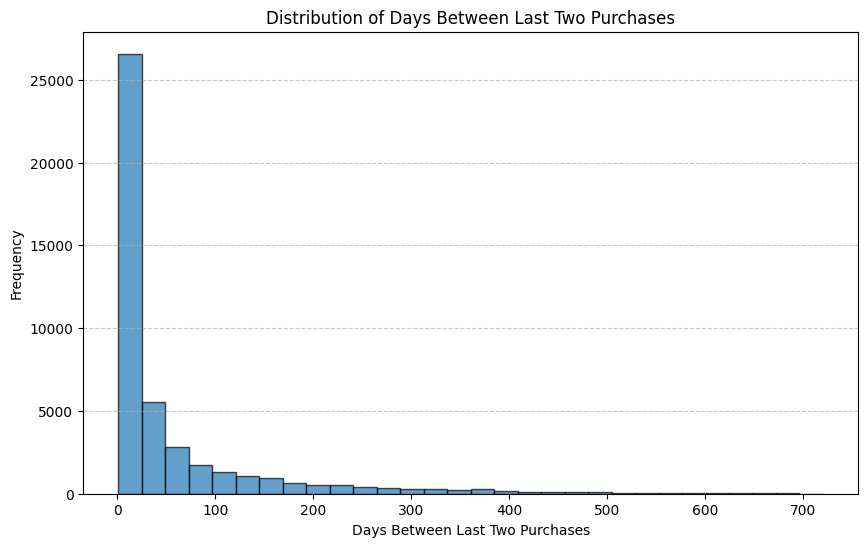

In [8]:
# Plot the distribution

result_filtered = result[result['days_between'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(result_filtered['days_between'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Days Between Last Two Purchases')
plt.ylabel('Frequency')
plt.title('Distribution of Days Between Last Two Purchases')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Seems like most clients ordered recently (less than 30 days between orders). Perhaps, we can use purchase recency as an indicator for churn.

In [9]:
df['client_id'].nunique()

170589

In [10]:
clients_not_frequent = result_filtered[result_filtered['days_between'] > 100]
clients_not_frequent.shape

(7454, 2)

In [11]:
clients_not_frequent = clients_not_frequent.merge(df, on='client_id')

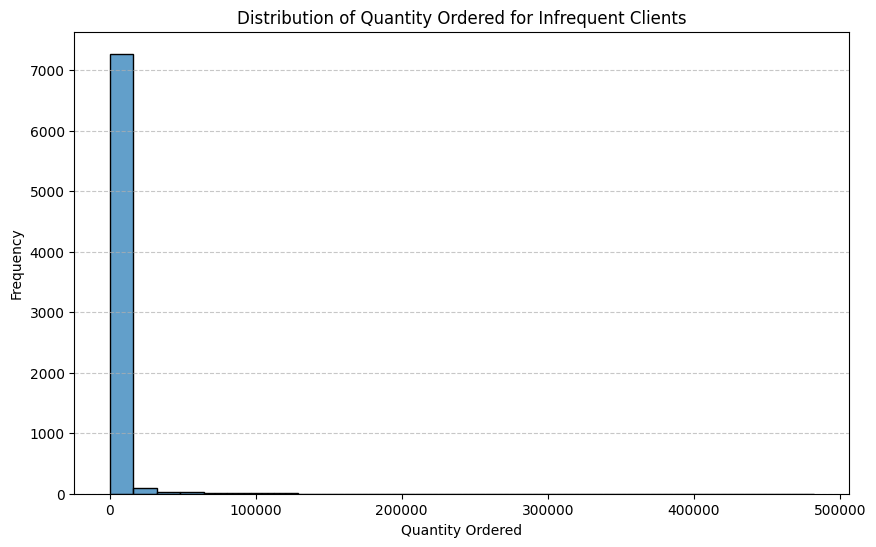

In [12]:
# Plot the distribution of quantity ordered for these clients

clients_not_frequent_quantity = clients_not_frequent.groupby('client_id')['quantity'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(clients_not_frequent_quantity['quantity'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Quantity Ordered')
plt.ylabel('Frequency')
plt.title('Distribution of Quantity Ordered for Infrequent Clients')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Churn Prediction

## 1. How Did You Define Customer Churn?
Since we don’t have proof that a client churned (unlike subscriptions), we need to identify clients who are **likely to churn** based on past transactions.

### **Churn Definition:**
- A client is labeled as **churned (1)** if their last purchase date is **older than 6 months** from the most recent order in the dataset.
- Otherwise, the client is considered **active (0).**

Using a **fixed time-based churn threshold** allows a simple yet customizable implementation, which can be modified based on the client’s business experience.

### **Alternative Considerations:**
- We considered adding a threshold based on **total quantity ordered**, since clients who order in bulk may buy less frequently.
- However, we opted for a **simpler definition** and used total quantity as a feature instead.

### **Churn Proportions in the Data:**
- **Total Clients Database:** 170,589
  - **Active Clients (0):** 120,349 (**70.55%**)
  - **Churned Clients (1):** 50,240 (**29.45%**)


In [28]:
client_relationship = pd.read_csv('sales_client_relationship_dataset.csv').set_index('client_id')
client_relationship.value_counts()

quali_relation  
Demanding client    56921
Agreeable client    56859
Difficult client    56809
Name: count, dtype: int64

In [29]:
# Define churn threshold
churn_threshold = df['date_order'].max() - pd.DateOffset(months=6)

# Aggregate data per client
client_features = df.groupby('client_id').agg(
    last_purchase=('date_order', 'max'),
    total_purchases=('date_order', 'count'),
    total_sales=('sales_net', 'sum'),
    total_quantity=('quantity', 'sum'),
    most_used_channel=('order_channel', lambda x: x.mode()[0]),  # Most frequent order channel
)

# Calculate recency and churn label
client_features['churn'] = ((client_features['last_purchase'] < churn_threshold)).astype(int)

# Drop last_purchase column as it's no longer needed
client_features.drop(columns=['last_purchase'], inplace=True)

# Include Client Relationship
client_features = client_features.join(client_relationship)
client_features

,total_purchases,total_sales,total_quantity,most_used_channel,churn,quali_relation
client_id,,,,,,
6,40,5.882233e+03,3038,by phone,0,Agreeable client
7,15,1.190777e+03,99,at the store,1,Difficult client
14,12339,3.043896e+06,1362031,by phone,0,Agreeable client
18,2194,2.180872e+05,72186,at the store,0,Agreeable client
25,4,3.745861e+02,108,at the store,1,Difficult client
...,...,...,...,...,...,...
2274456,22,1.542821e+03,776,at the store,0,Difficult client
2274479,8,3.414718e+02,34,at the store,1,Agreeable client
2274504,4,1.132566e+02,14,at the store,1,Demanding client


In [30]:
# Frequency: Number of distinct purchase occasions
#client_features['purchase_frequency'] = df.groupby('client_id')['date_order'].nunique()

# Time Since First Purchase: Measures loyalty
first_purchase = df.groupby('client_id')['date_order'].min()
client_features['customer_lifetime'] = (df['date_order'].max() - first_purchase).dt.days

# Purchase Interval (Consistency of Orders)
# Calculate the difference between consecutive purchases for each client
df_sorted = df.sort_values(['client_id', 'date_order'])  # Ensure sorted by client and date
df_sorted['purchase_gap'] = df_sorted.groupby('client_id')['date_order'].diff().dt.days

# Compute the average purchase interval per client
client_features['avg_purchase_interval'] = df_sorted.groupby('client_id')['purchase_gap'].mean().fillna(0)

# Distinct Products Purchased
client_features['unique_products'] = df.groupby('client_id')['product_id'].nunique()

# Number of Order Channels Used
client_features['unique_channels'] = df.groupby('client_id')['order_channel'].nunique()

## 2. What Input Variables Did We Use?
The model was trained on the following **client-based features:**

| Feature | Description |
|---------|-------------|
| **total_purchases** | Total number of orders made by the client |
| **total_sales** | Total revenue generated by the client |
| **total_quantity** | Total quantity of products purchased |
| **most_used_channel** | Most frequent order channel used by the client |
| **customer_lifetime** | Number of days since the client’s first purchase (~loyalty) |
| **avg_purchase_interval** | Average time gap (in days) between consecutive purchases |

Additionally, we included **client relationship data** to capture behaviors such as whether the client is **Demanding, Difficult, or Agreeable**, which could impact churn likelihood.

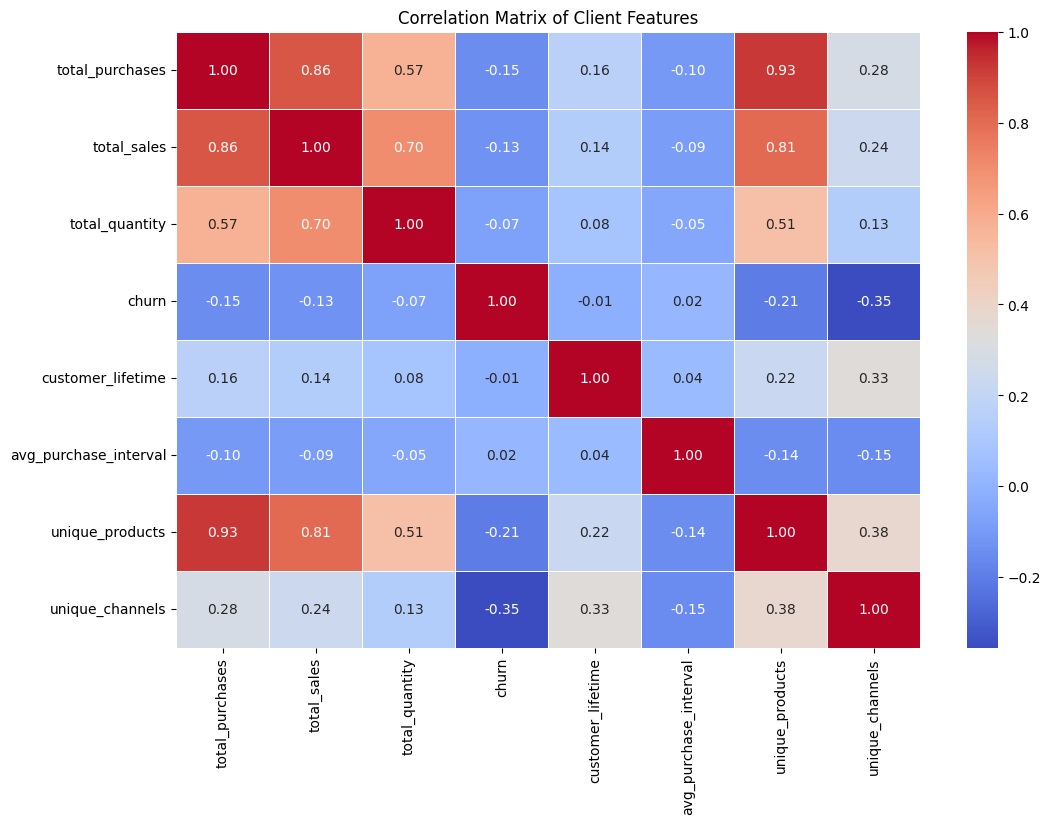

In [31]:
# Compute the correlation matrix
correlation_matrix = client_features.select_dtypes(include=['number']).corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Client Features")
plt.show()

In [32]:
# Compute churn counts
churn_counts = client_features['churn'].value_counts()

# Compute ratios (percentages)
churn_ratios = churn_counts / churn_counts.sum() * 100

# Combine counts and ratios into a single DataFrame
churn_summary = pd.DataFrame({
    'count': churn_counts,
    'percentage': churn_ratios
})

churn_summary

,count,percentage
churn,,
0,120349,70.549098
1,50240,29.450902


In [33]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = client_features.drop(columns=['churn'])
y = client_features['churn']

# Convert categorical features to numerical
X = pd.get_dummies(X, columns=['most_used_channel', 'quali_relation'], drop_first=True)

# Normalize numerical features
numeric_features = X.select_dtypes(include=['number']).columns

# Apply log transformation to highly skewed columns
X[numeric_features] = np.log1p(X[numeric_features])  # log1p avoids log(0) issues

X.fillna(0, inplace=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c:\Users\adana\anaconda3\envs\myenv\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


## 3. What Model Did We Use?
For churn prediction, we used a **Logistic Regression model**.

### **Why Logistic Regression?**
- Unlike complex black-box models, Logistic Regression provides **probability scores**, helping us understand the likelihood of churn for each customer.
- We can **analyze feature coefficients** to determine the most important churn factors.
- It offers **fast training and inference times**, making it scalable for large datasets and easy to **retrain with new data**.

## 4. How to Interpret the Performance of the Model?
The Logistic Regression model achieved the following results:

### **Performance Metrics:**
- **Accuracy:** **92.2%** → The percentage of correctly classified churners and non-churners.
- **Precision:**
  - **Churned (1):** **0.96** → When the model predicts a customer will churn, it is correct **96%** of the time.
  - **Active (0):** **0.91** → When the model predicts a customer will stay, it is correct **93%** of the time.
- **Recall:**
  - **Churned (1):** **0.77** → The model correctly identifies **77%** of actual churners.
  - **Active (0):** **0.99** → The model correctly identifies **99%** of active clients.

In [34]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9219766692068703
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     24196
           1       0.96      0.77      0.85      9922

    accuracy                           0.92     34118
   macro avg       0.93      0.88      0.90     34118
weighted avg       0.92      0.92      0.92     34118



c:\Users\adana\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8438360982472595
              precision    recall  f1-score   support

           0       0.86      0.94      0.89     24196
           1       0.80      0.62      0.70      9922

    accuracy                           0.84     34118
   macro avg       0.83      0.78      0.80     34118
weighted avg       0.84      0.84      0.84     34118



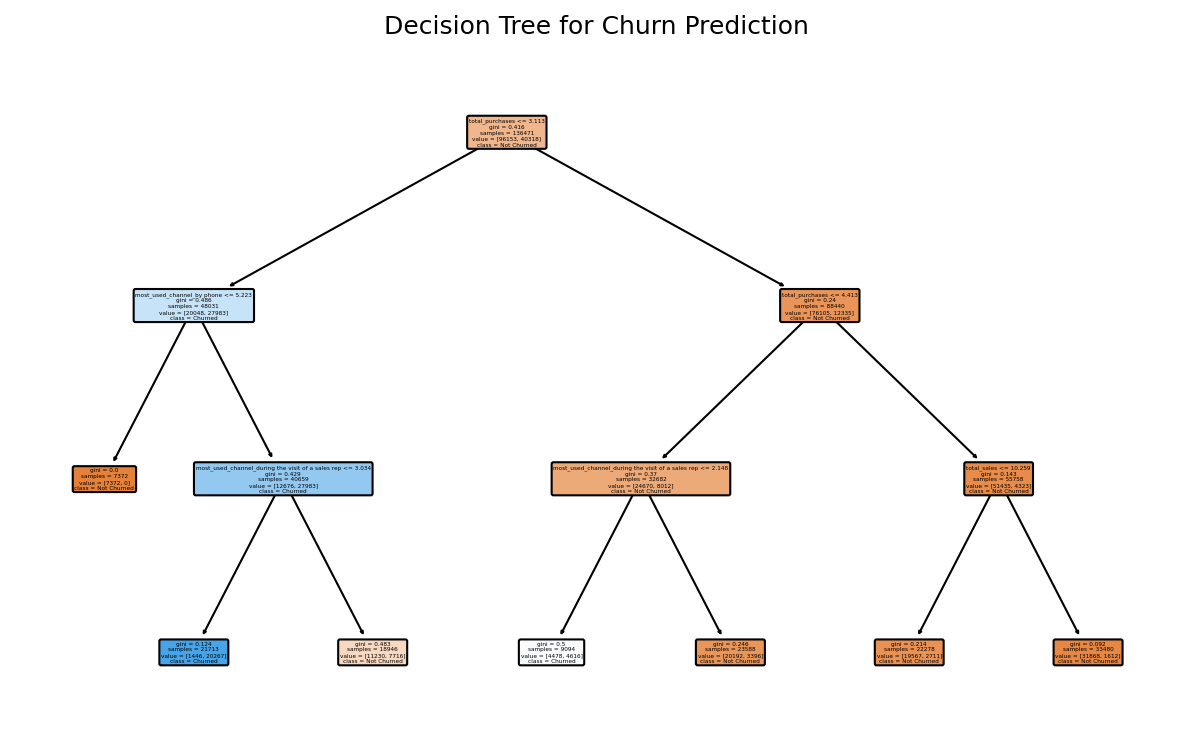

In [35]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression Classifier
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

# Predictions
y_pred = tree.predict(X_test)

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

features = [
    'total_purchases', 'total_sales', 'total_quantity',
    'most_used_channel_by phone',
    'most_used_channel_during the visit of a sales rep',
    'most_used_channel_online', 'most_used_channel_other',
    'quali_relation_Demanding client', 'quali_relation_Difficult client'
]

# Plot the decision tree
plt.figure(figsize=(10, 6), dpi=150)
plot_tree(tree, feature_names=features, class_names=['Not Churned', 'Churned'], filled=True, rounded=True)
plt.title("Decision Tree for Churn Prediction")
plt.show()

In [36]:
# Predict churn probabilities
client_features['churn_probability'] = log_reg.predict_proba(X)[:, 1]  # Probability of churn

# Show top at-risk clients
at_risk_clients = client_features.sort_values(by='churn_probability', ascending=False)
at_risk_clients.head(20)


,total_purchases,total_sales,total_quantity,most_used_channel,churn,quali_relation,customer_lifetime,avg_purchase_interval,unique_products,unique_channels,churn_probability
client_id,,,,,,,,,,,
1593885,1,19.4580,3,online,1,Agreeable client,726,0.0,1,1,1.0
1293659,1,4.9956,3,at the store,1,Demanding client,727,0.0,1,1,1.0
515945,1,13.5240,3,by phone,1,Agreeable client,726,0.0,1,1,1.0
1722781,1,9.4300,5,at the store,1,Demanding client,726,0.0,1,1,1.0
1024778,1,14.9868,3,at the store,1,Agreeable client,727,0.0,1,1,1.0
189617,1,10.4949,9,at the store,1,Agreeable client,727,0.0,1,1,1.0
1978720,1,6.7390,5,at the store,1,Difficult client,725,0.0,1,1,1.0
549644,1,10.8468,3,at the store,1,Agreeable client,725,0.0,1,1,1.0
1095246,1,21.3440,5,at the store,1,Agreeable client,727,0.0,1,1,1.0


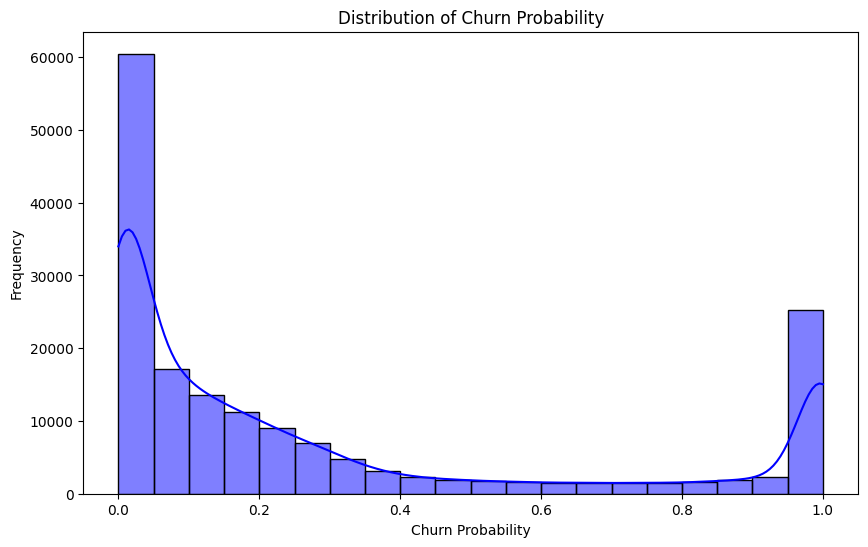

In [37]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot histogram with KDE (optional)
sns.histplot(at_risk_clients['churn_probability'], bins=20, kde=True, color='blue')

# Labels and title
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Churn Probability')

# Show plot
plt.show()


## 5. Feature Importance Ranking
### **Top 3 Most Important Features in Churn Prediction:**

1. **Customer Lifetime (Most Important)**
   - Customers with a **longer lifetime** are less likely to churn as they have built a purchasing habit.
   - **Newer customers** might churn faster if they don’t establish a routine of buying.
   - If customer lifetime is **low**, they may not have had enough engagement, increasing churn risk.

2. **Average Purchase Interval**
   - Customers who buy **frequently** are less likely to churn.
   - If a customer's **purchase interval starts increasing**, it may indicate decreasing engagement and a **higher churn risk**.
   - **Long purchase intervals** mean customers don’t feel the need to buy often, making retention harder.

3. **Total Purchases**
   - Customers with **more purchases** are less likely to churn.
   - Customers with **few purchases** haven’t built loyalty and may leave easily.
   - **High churn risk** if total purchase count is **low**.


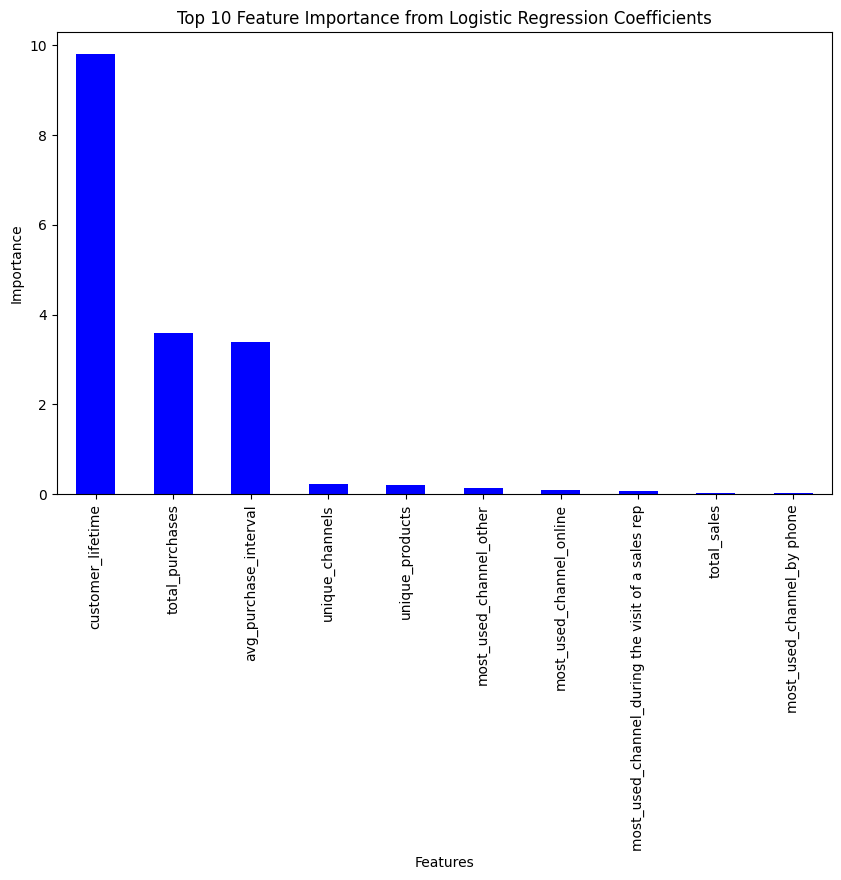

In [38]:
# Get feature importance (absolute values of coefficients)
feature_importance = pd.Series(abs(log_reg.coef_[0]), index=X_train.columns)

# Sort and plot
feature_importance.sort_values(ascending=False).iloc[:10].plot(kind='bar', figsize=(10,6), color='blue')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 10 Feature Importance from Logistic Regression Coefficients")
plt.show()


In [39]:
client_features.reset_index(inplace=True)

In [40]:
client_features

,client_id,total_purchases,total_sales,total_quantity,most_used_channel,churn,quali_relation,customer_lifetime,avg_purchase_interval,unique_products,unique_channels,churn_probability
0,6,40,5.882233e+03,3038,by phone,0,Agreeable client,695,16.794872,37,2,2.228119e-01
1,7,15,1.190777e+03,99,at the store,1,Difficult client,433,11.500000,10,1,2.986399e-01
2,14,12339,3.043896e+06,1362031,by phone,0,Agreeable client,727,0.058762,4898,3,2.048923e-06
3,18,2194,2.180872e+05,72186,at the store,0,Agreeable client,726,0.326493,786,3,7.586727e-04
4,25,4,3.745861e+02,108,at the store,1,Difficult client,347,0.000000,4,1,9.999507e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
170584,2274456,22,1.542821e+03,776,at the store,0,Difficult client,27,0.333333,16,2,3.957561e-10
170585,2274479,8,3.414718e+02,34,at the store,1,Agreeable client,692,69.285714,5,1,5.323369e-01
170586,2274504,4,1.132566e+02,14,at the store,1,Demanding client,689,141.666667,4,2,4.505651e-01
170587,2274508,8,0.000000e+00,228,at the store,1,Difficult client,704,0.000000,4,1,9.999997e-01


## Plots

In [41]:
high_risk_clients = at_risk_clients[at_risk_clients['churn_probability'] > 0.9]
high_risk_clients.reset_index(inplace=True)

In [42]:
high_risk_clients

,client_id,total_purchases,total_sales,total_quantity,most_used_channel,churn,quali_relation,customer_lifetime,avg_purchase_interval,unique_products,unique_channels,churn_probability
0,1593885,1,19.458000,3,online,1,Agreeable client,726,0.000000,1,1,1.000000
1,1293659,1,4.995600,3,at the store,1,Demanding client,727,0.000000,1,1,1.000000
2,515945,1,13.524000,3,by phone,1,Agreeable client,726,0.000000,1,1,1.000000
3,1722781,1,9.430000,5,at the store,1,Demanding client,726,0.000000,1,1,1.000000
4,1024778,1,14.986800,3,at the store,1,Agreeable client,727,0.000000,1,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
27546,1594066,58,2903.330327,510,at the store,1,Demanding client,713,3.736842,45,2,0.900126
27547,1982903,3,291.439747,49,at the store,1,Difficult client,620,66.000000,3,1,0.900083
27548,280159,12,892.724607,386,by phone,1,Difficult client,656,20.000000,10,1,0.900042
27549,1259557,9,816.203760,57,at the store,1,Difficult client,683,29.625000,9,2,0.900019


In [46]:
print(f"${df['sales_net'].sum():,.2f}")

$9,167,251,277.01


In [47]:
revenue_loss = (high_risk_clients['total_sales'] * high_risk_clients['churn_probability']).sum()
print(f"Expected Revenue Loss: ${revenue_loss:,.2f}")

Expected Revenue Loss: $49,989,413.74


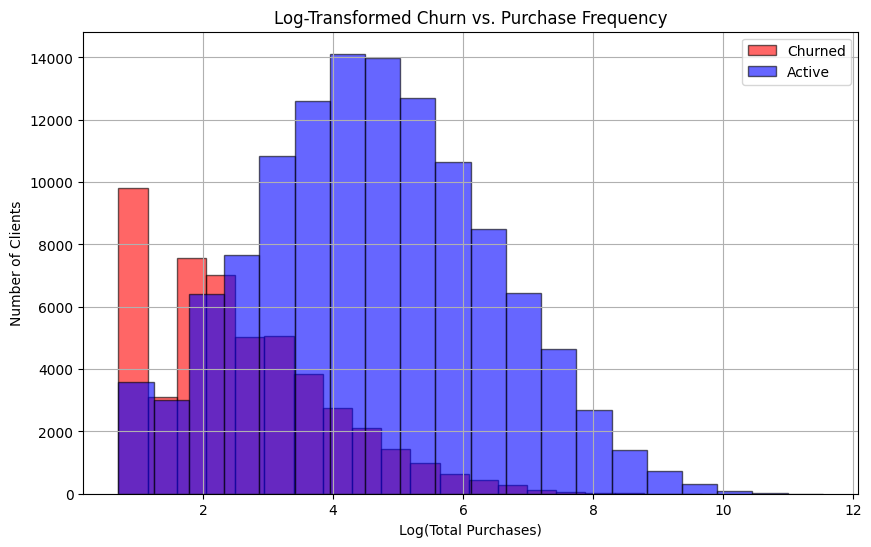

In [194]:
plt.figure(figsize=(10, 6))

# Apply log transformation
log_purchases_churned = np.log1p(client_features[client_features['churn'] == 1]['total_purchases'])
log_purchases_active = np.log1p(client_features[client_features['churn'] == 0]['total_purchases'])

# Plot histograms for log-transformed data
plt.hist(log_purchases_churned, bins=20, alpha=0.6, label="Churned", edgecolor='black', color='red')
plt.hist(log_purchases_active, bins=20, alpha=0.6, label="Active", edgecolor='black', color='blue')

plt.title("Log-Transformed Churn vs. Purchase Frequency")
plt.xlabel("Log(Total Purchases)")
plt.ylabel("Number of Clients")
plt.legend()
plt.grid()
plt.show()


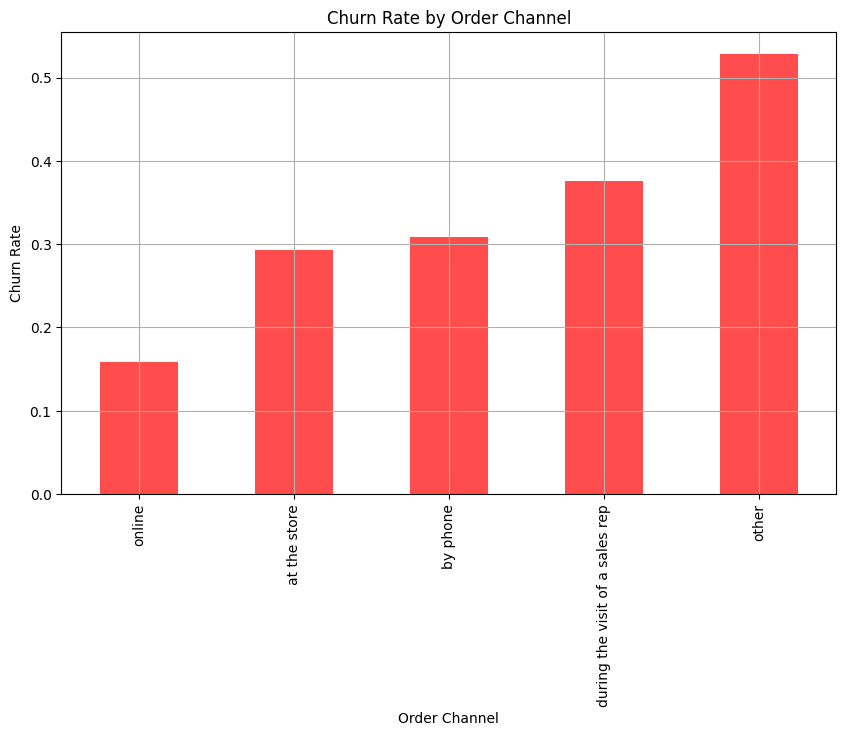

In [191]:
churn_by_channel = client_features.groupby('most_used_channel')['churn'].mean()  # Churn rate per channel

plt.figure(figsize=(10, 6))
churn_by_channel.sort_values().plot(kind='bar', color='red', alpha=0.7)
plt.title("Churn Rate by Order Channel")
plt.xlabel("Order Channel")
plt.ylabel("Churn Rate")
plt.grid()
plt.show()


In [198]:
high_risk_clients_ids = high_risk_clients[['client_id', 'churn_probability']]
high_risk_clients_ids

,client_id,churn_probability
0,2025330,1.000000
1,689107,1.000000
2,735539,1.000000
3,1103635,1.000000
4,2193330,1.000000
...,...,...
27923,2036736,0.900095
27924,277326,0.900047
27925,28880,0.900036
27926,1538619,0.900019


In [200]:
high_risk_clients_df = high_risk_clients_ids.merge(df, on='client_id')
high_risk_clients_df

,client_id,churn_probability,date_order,date_invoice,product_id,sales_net,quantity,order_channel,branch_id
0,2025330,1.000000,2017-10-03,2017-10-20,2169352,17219.6400,3,by phone,1888
1,689107,1.000000,2017-09-26,2017-09-26,1693739,568.1184,3,at the store,6654
2,735539,1.000000,2017-10-03,2017-10-03,2565691,1070.8524,3,at the store,10902
3,1103635,1.000000,2017-09-25,2017-10-02,903592,1325.4900,3,by phone,8711
4,2193330,1.000000,2017-09-27,2017-09-27,2400831,419.6856,3,at the store,10236
...,...,...,...,...,...,...,...,...,...
301565,2040708,0.900002,2018-08-16,2018-08-16,3000784,2.2908,3,at the store,9110
301566,2040708,0.900002,2018-08-16,2018-08-16,499483,918.8592,3,at the store,9110
301567,2040708,0.900002,2018-08-16,2018-08-16,1250432,745.7796,3,at the store,9110
301568,2040708,0.900002,2018-08-16,2018-08-16,41131,658.8120,3,at the store,9110


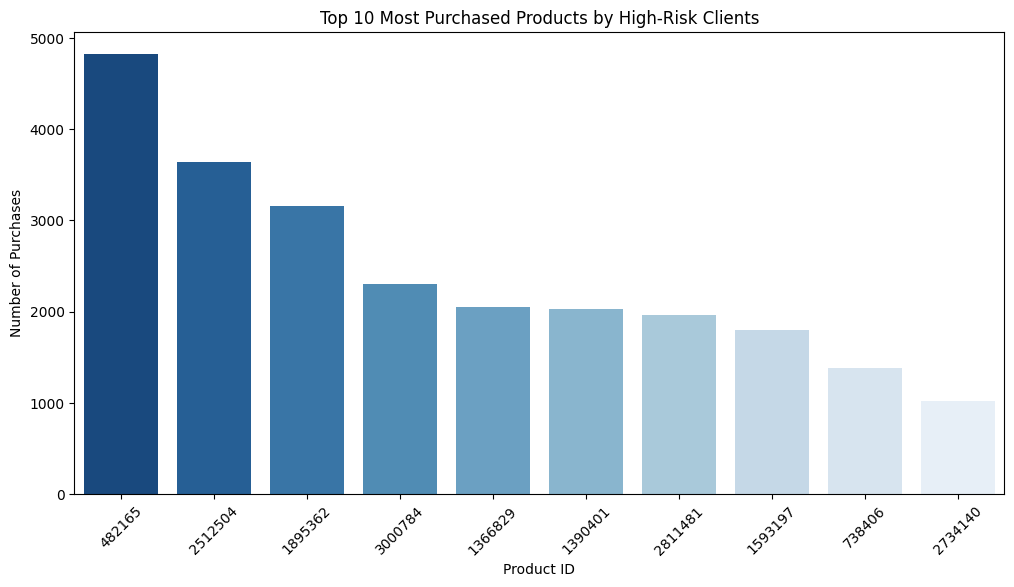

In [ ]:
# Get the top 10 most frequently purchased products
top_products = high_risk_clients_df['product_id'].value_counts().sort_values(ascending=False).head(10).reset_index()
top_products['product_id'] = top_products['product_id'].astype(str)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products['product_id'], y=top_products['count'], palette="Blues_r")

plt.xlabel("Product ID")
plt.ylabel("Number of Purchases")
plt.title("Top 10 Most Purchased Products by High-Risk Clients")
plt.xticks(rotation=45)
plt.show()


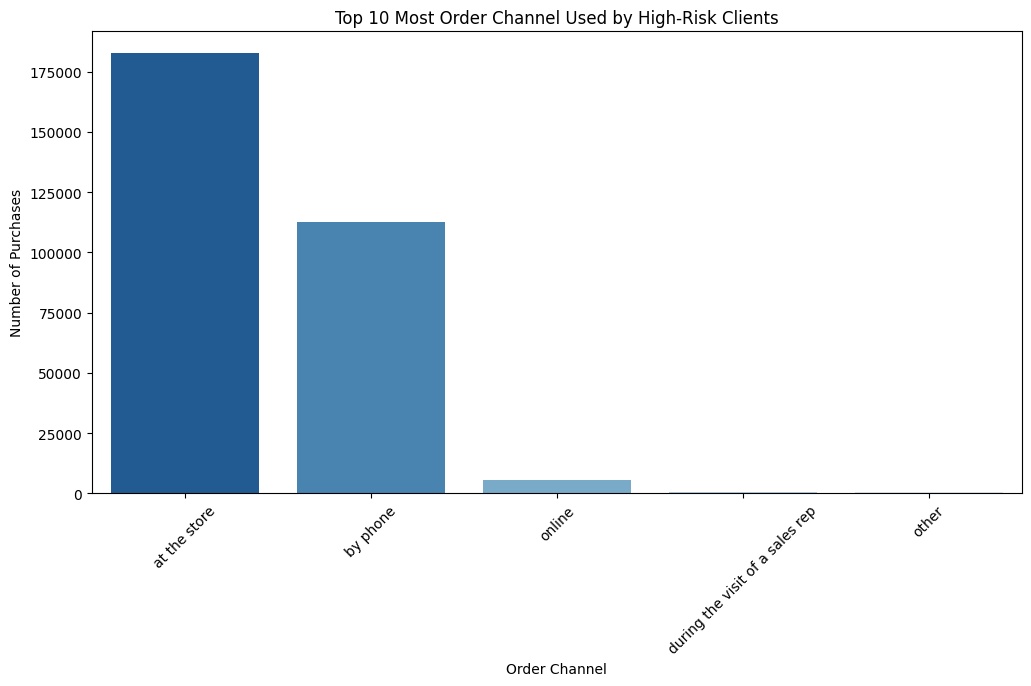

In [231]:
# Get the top 10 most frequently purchased products
top_channels = high_risk_clients_df['order_channel'].value_counts().sort_values(ascending=False).head(10).reset_index()

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_channels['order_channel'], y=top_channels['count'], palette="Blues_r")

plt.xlabel("Order Channel")
plt.ylabel("Number of Purchases")
plt.title("Top 10 Most Order Channel Used by High-Risk Clients")
plt.xticks(rotation=45)
plt.show()

## 6. Retention Strategy

| Feature | Retention Strategy |
|---------|--------------------|
| **Customer Lifetime** | Engage **new customers early** (welcome offers, onboarding). Keep long-time customers engaged. |
| **Avg. Purchase Interval** | Identify customers with **increasing gaps**. Use **reminders, limited-time deals**. |
| **Total Purchases** | Convert occasional buyers into **repeat customers** with **loyalty programs, personalized discounts**. |


In [ ]:
high_risk_clients['retention_priority'] = (
    high_risk_clients['churn_probability'] * high_risk_clients['total_sales']
)
high_risk_clients = high_risk_clients.sort_values('retention_priority', ascending=False)
high_risk_clients

C:\Users\adana\AppData\Local\Temp\ipykernel_34236\1165776281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk_clients['retention_priority'] = (


,client_id,total_purchases,total_sales,total_quantity,most_used_channel,churn,quali_relation,customer_lifetime,avg_purchase_interval,unique_products,unique_channels,churn_probability,retention_priority,suggested_action
10674,330586,5,1.251371e+06,822665,by phone,1,Difficult client,501,0.000000,4,1,0.999996,1.251365e+06,Offer discount
7651,271058,4,9.946438e+05,14216,by phone,1,Difficult client,579,0.000000,2,1,1.000000,9.946433e+05,Offer discount
21934,1002324,108,4.827756e+05,31626,by phone,1,Agreeable client,675,0.000000,108,1,0.987766,4.768693e+05,Offer discount
24455,747119,61,4.542449e+05,23679,by phone,1,Demanding client,723,2.166667,46,2,0.963169,4.375147e+05,Offer discount
27376,945770,194,3.390441e+05,2034,by phone,1,Agreeable client,727,0.445596,9,2,0.903999,3.064955e+05,Offer discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17337,1427668,4,-1.352989e+02,32,at the store,1,Agreeable client,250,0.000000,1,1,0.999221,-1.351935e+02,Send personalized email
13451,229580,22,-1.715089e+02,256,at the store,1,Agreeable client,615,0.000000,7,1,0.999961,-1.715022e+02,Send personalized email
1723,2179578,2,-1.803200e+02,10,at the store,1,Demanding client,702,0.000000,1,2,1.000000,-1.803200e+02,Call for feedback
19597,463080,27,-1.818564e+02,101,at the store,1,Agreeable client,606,1.846154,13,1,0.996573,-1.812332e+02,Send personalized email


In [ ]:
high_risk_clients['total_sales'].describe()

count    2.755100e+04
mean     1.852017e+03
std      1.208808e+04
min     -3.618736e+02
25%      1.286905e+02
50%      4.236030e+02
75%      1.337282e+03
max      1.251371e+06
Name: total_sales, dtype: float64

In [ ]:
client_features['suggested_action'] = client_features.apply(lambda x:
    'Offer discount' if x['total_sales'] > 1000 else
    'Call for feedback' if x['total_purchases'] < 3 else
    'Send personalized email', axis=1
)
client_features

,client_id,total_purchases,total_sales,total_quantity,most_used_channel,churn,quali_relation,customer_lifetime,avg_purchase_interval,unique_products,unique_channels,churn_probability,retention_priority,suggested_action
10674,330586,5,1.251371e+06,822665,by phone,1,Difficult client,501,0.000000,4,1,0.999996,1.251365e+06,Offer discount
7651,271058,4,9.946438e+05,14216,by phone,1,Difficult client,579,0.000000,2,1,1.000000,9.946433e+05,Offer discount
21934,1002324,108,4.827756e+05,31626,by phone,1,Agreeable client,675,0.000000,108,1,0.987766,4.768693e+05,Offer discount
24455,747119,61,4.542449e+05,23679,by phone,1,Demanding client,723,2.166667,46,2,0.963169,4.375147e+05,Offer discount
27376,945770,194,3.390441e+05,2034,by phone,1,Agreeable client,727,0.445596,9,2,0.903999,3.064955e+05,Offer discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17337,1427668,4,-1.352989e+02,32,at the store,1,Agreeable client,250,0.000000,1,1,0.999221,-1.351935e+02,Send personalized email
13451,229580,22,-1.715089e+02,256,at the store,1,Agreeable client,615,0.000000,7,1,0.999961,-1.715022e+02,Send personalized email
1723,2179578,2,-1.803200e+02,10,at the store,1,Demanding client,702,0.000000,1,2,1.000000,-1.803200e+02,Call for feedback
19597,463080,27,-1.818564e+02,101,at the store,1,Agreeable client,606,1.846154,13,1,0.996573,-1.812332e+02,Send personalized email


In [70]:
high_risk_clients['suggested_action'].value_counts()

suggested_action
Send personalized email    10229
Call for feedback           8887
Offer discount              8435
Name: count, dtype: int64

In [71]:
high_risk_clients.to_csv('high_risk_clients_v2.csv', index=False)

## 7. Key Takeaways
- **The model performs well overall** (high accuracy and precision).  
- **Recall for churners (0.77) is lower than for active clients (0.99)** → Some actual churners are missed, leading to lost revenue.  
- While **advanced models** could be explored, the focus is on **interpretability and actionable insights** rather than just model performance.